# Load Lib

In [580]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, date 
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
# Import Normalizer
from sklearn.preprocessing import Normalizer
import os
import plotly_express as px# Visualization
import plotly.graph_objects as go# Visualization
from plotly.subplots import make_subplots# Visualization
import gc
import warnings # Supress warnings 
# Import data generation function and set random seed
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
#Ml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# DL

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Multiply, Add, LSTM, LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
warnings.filterwarnings('ignore')

In [581]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [582]:
TrainData= '/home/abderrazak/ALLINHERE/NLP/Datacamp/sag_data_train.csv'
TestData= '/home/abderrazak/ALLINHERE/NLP/Datacamp/sag_data_test.csv'
#df = pd.read_csv(TrainData)
TrainData = pd.read_csv(TrainData, index_col="Time", parse_dates=True)
#df = pd.read_csv(TrainData, index_col='Time', parse_dates=True)
TestData = pd.read_csv(TestData, index_col="Time", parse_dates=True)

In [583]:
TrainData=reduce_mem_usage(TrainData)

Memory usage of dataframe is 7.38 MB
Memory usage after optimization is: 6.59 MB
Decreased by 10.7%


In [584]:
TestData=reduce_mem_usage(TestData)

Memory usage of dataframe is 1.54 MB
Memory usage after optimization is: 1.37 MB
Decreased by 10.7%


In [585]:
TrainData.shape

(138241, 6)

In [586]:
TrainData=TrainData.drop_duplicates().dropna()

In [587]:
TrainData.shape

(138238, 6)

In [588]:
TestData.shape

(28801, 6)

In [589]:
TrainData.columns

Index(['Bearing Pressure (kPa)', 'Power Draw (MW)', 'Speed (RPM)',
       'Dilution Flow Rate (m3/h)', 'Conveyor Belt Feed Rate (t/h)',
       'Conveyor Belt PSD Fines (%)'],
      dtype='object')

# Prepare features /Target:

Use the data from all the variables as your model inputs.

The targets for the predictions are the two performance variables at 5 minutes into the future.


### Train Data

In [590]:
# Create arrays for the features and the response variable
y_train_raw= TrainData[['Bearing Pressure (kPa)', 'Power Draw (MW)']].to_numpy()
X_train_raw = TrainData.to_numpy()

### Test Data

In [591]:
# Create arrays for the features and the response variable
y_test_raw = TestData[['Bearing Pressure (kPa)', 'Power Draw (MW)']].to_numpy()
X_test_raw = TestData.to_numpy()

# Forcasting (LSTM model)


## Data Preprocessing
We need to “chop the data” into smaller sequences for our model. Preparing the data for Time Series forecasting (LSTMs in particular) can be tricky. Intuitively, we need to predict the value at the current time step by using the history (n time steps from it). Here’s a generic function that does the job: We need to reshape our data into three dimensions so that it can be used by LSTM. The input to LSTM layer should be in 3D shape i.e. (samples, time-steps, features). The samples are the number of samples in the input data.We have 138241 rows'samples' in total and 6 columns in our dataset.

We will reshape our dataset into 138241 samples, 10 time-steps(10 last min), and 6 features.

We will predict target 5 min in the future 

def create_dataset(X, y, time_steps=1, futur_step=0):
    Xs, ys = [], []
    for i in range(len(X) - time_steps-futur_step):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps+futur_step])
    return np.array(Xs), np.array(ys)

In [592]:
def create_dataset(xtrain,ytrain, n_past, n_future):
      #
      # n_past ==> no of past observations
      #
      # n_future ==> no of future observations 
      #
    X, y = list(), list()
    for window_start in range(len(xtrain)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end >= len(xtrain):
            break
        # slicing the past and future parts of the window
        past = xtrain[window_start:past_end, :]
        future=ytrain[future_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [593]:
scaler1 = MinMaxScaler()
TrainData_Scaled = scaler1.fit_transform(X_train_raw)
TestData_Scaled = scaler1.transform(X_test_raw)

In [594]:
scaler2 = MinMaxScaler()
TrainTarget_Scaled = scaler2.fit_transform(y_train_raw)
TestTarget_Scaled= scaler2.transform(y_test_raw)

In [595]:
TrainTarget_Scaled[5]

array([0.91470002, 0.78228411])

In [596]:

X_train, Y_train = create_dataset(TrainData_Scaled, TrainTarget_Scaled,10,5 )
X_test, Y_test = create_dataset(TestData_Scaled, TestTarget_Scaled, 10, 5)



In [597]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(138223, 10, 6) (138223, 2) (28786, 10, 6) (28786, 2)


In [598]:
print(X_train[0:10])

[[[0.9148521  0.78532311 0.89845375 0.62976225 0.81679438 0.45612094]
  [0.90407268 0.77245007 0.87990569 0.63543281 0.81475591 0.5339233 ]
  [0.91718146 0.74756655 0.86072663 0.63137981 0.8121946  0.45685841]
  [0.91312177 0.73862769 0.86966992 0.63250318 0.8306616  0.50589971]
  [0.91818057 0.76414331 0.891737   0.63685022 0.80827821 0.59623894]
  [0.91470002 0.78228411 0.90961212 0.63145707 0.81996625 0.55862832]
  [0.91352575 0.78109725 0.89392086 0.63835588 0.80375254 0.46091445]
  [0.91404768 0.76887056 0.87915984 0.62267071 0.83707353 0.52728614]
  [0.91468613 0.77650401 0.89835775 0.6357827  0.80476932 0.53207965]
  [0.90909939 0.78845353 0.90263217 0.63765717 0.83192192 0.5759587 ]]

 [[0.90407268 0.77245007 0.87990569 0.63543281 0.81475591 0.5339233 ]
  [0.91718146 0.74756655 0.86072663 0.63137981 0.8121946  0.45685841]
  [0.91312177 0.73862769 0.86966992 0.63250318 0.8306616  0.50589971]
  [0.91818057 0.76414331 0.891737   0.63685022 0.80827821 0.59623894]
  [0.91470002 0.78

In [599]:
print(Y_train[0:10])

[[0.91939126 0.80874057]
 [0.91830584 0.8013898 ]
 [0.91821533 0.81213457]
 [0.90757661 0.8052388 ]
 [0.9109364  0.82063316]
 [0.91721674 0.83793927]
 [0.91668488 0.83230906]
 [0.91462322 0.82513887]
 [0.9084221  0.82424458]
 [0.9064966  0.80955729]]


In [600]:
print(TrainData_Scaled[0:10])

[[0.9148521  0.78532311 0.89845375 0.62976225 0.81679438 0.45612094]
 [0.90407268 0.77245007 0.87990569 0.63543281 0.81475591 0.5339233 ]
 [0.91718146 0.74756655 0.86072663 0.63137981 0.8121946  0.45685841]
 [0.91312177 0.73862769 0.86966992 0.63250318 0.8306616  0.50589971]
 [0.91818057 0.76414331 0.891737   0.63685022 0.80827821 0.59623894]
 [0.91470002 0.78228411 0.90961212 0.63145707 0.81996625 0.55862832]
 [0.91352575 0.78109725 0.89392086 0.63835588 0.80375254 0.46091445]
 [0.91404768 0.76887056 0.87915984 0.62267071 0.83707353 0.52728614]
 [0.91468613 0.77650401 0.89835775 0.6357827  0.80476932 0.53207965]
 [0.90909939 0.78845353 0.90263217 0.63765717 0.83192192 0.5759587 ]]


In [601]:
print(TrainTarget_Scaled[0:10])

[[0.9148521  0.78532311]
 [0.90407268 0.77245007]
 [0.91718146 0.74756655]
 [0.91312177 0.73862769]
 [0.91818057 0.76414331]
 [0.91470002 0.78228411]
 [0.91352575 0.78109725]
 [0.91404768 0.76887056]
 [0.91468613 0.77650401]
 [0.90909939 0.78845353]]


# Solution via Simple LSTM

In [602]:
X_train.shape

(138223, 10, 6)

In [603]:
#Solution via Simple LSTM

modelSimpleLSTM = tf.keras.Sequential()
modelSimpleLSTM.add(layers.LSTM(50, activation='relu', input_shape=(10, 6)))
modelSimpleLSTM.add(layers.Dense(2))  
#optimizer='adam'
#optimizer =tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop(0.001)
 ## Compile model
#epochs = 50
#learning_rate = 0.1
#decay_rate = learning_rate / epochs
#momentum = 0.8
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
#optimizer=sgd
modelSimpleLSTM.compile(loss='mse',
            optimizer='adam',
            metrics=['mse'])

# configure early stopping
es = EarlyStopping(monitor='val_mse',min_delta=0.0000000000001, patience=5)
historySimpleLSTM = modelSimpleLSTM.fit(X_train, Y_train,batch_size=64, epochs=1000, validation_split=0.1, verbose=0,callbacks=[es])

**min_delta** : minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

**patience** : number of epochs with no improvement after which training will be stopped.


In [604]:
modelSimpleLSTM.save('/home/abderrazak/ALLINHERE/NLP/Datacamp/modelSimpleLSTM.h5') 

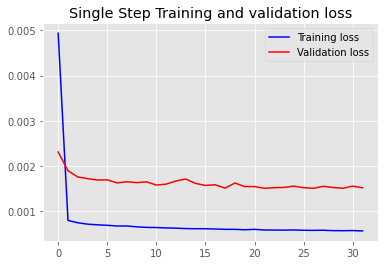

In [605]:
def plot_train_history(history, title):
    loss = history.history['mse']
    val_loss = history.history['val_mse']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
plot_train_history(historySimpleLSTM,
                   'Single Step Training and validation loss')

In [606]:
loss_SimpleLSTM,MSE_SimpleLSTM = modelSimpleLSTM.evaluate( X_test, Y_test, verbose=0)
print('MSE_SimpleLSTM: %f' % (MSE_SimpleLSTM*100))
print('loss_SimpleLSTM_model: %f' % (loss_SimpleLSTM*100))

MSE_SimpleLSTM: 0.090466
loss_SimpleLSTM_model: 0.090466


# Solution via Stacked LSTM
Let's now create a more complex LSTM with multiple LSTM and dense layers and see if we can improve our answer:

In [607]:
#Solution via Stacked LSTM
#The following script trains a stacked LSTM and makes predictions on test point:
def build_model():
    model3 = tf.keras.Sequential()
    model3.add(layers.LSTM(200, activation='relu',return_sequences=True, input_shape=(10, 6)))
    model3.add(layers.LSTM(100, activation='relu',return_sequences=True))
    model3.add(layers.LSTM(50, activation='relu',return_sequences=True))
    model3.add(layers.LSTM(25, activation='relu'))
    model3.add(layers.Dense(20, activation='relu'))
    model3.add(layers.Dense(10, activation='relu'))
    model3.add(layers.Dense(2))  
    #optimizer='adam'
    optimizer =tf.keras.optimizers.Adam()
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
     ## Compile model
    #epochs = 50
    #learning_rate = 0.1
    #decay_rate = learning_rate / epochs
    #momentum = 0.8
    #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    #optimizer=sgd
    model3.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model3
model3 = build_model()
history = model3.fit(X_train, Y_train,batch_size=64, epochs=1000, validation_split=0.1,verbose=0,callbacks=[es])

In [608]:
model3.save('/home/abderrazak/ALLINHERE/NLP/Datacamp/my_model3StackLSTM.h5')

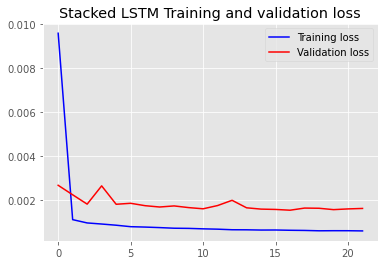

In [651]:
def plot_train_history(history, title):
    loss = history.history['mse']
    val_loss = history.history['val_mse']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
plot_train_history(history,
                   'Stacked LSTM Training and validation loss')

In [611]:
# evaluate the keras model
loss3, mae3, mse3 = model3.evaluate( X_test, Y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae3))

900/900 - 4s - loss: 7.8964e-04 - mae: 0.0139 - mse: 7.8964e-04
Testing set Mean Abs Error:  0.01 MPG


In [652]:
Testpred = model3.predict(X_test)
Testpred

array([[0.90042084, 0.85827684],
       [0.8994561 , 0.8539208 ],
       [0.89989567, 0.8514209 ],
       ...,
       [0.87949103, 0.93482745],
       [0.8827324 , 0.94125426],
       [0.88140017, 0.93898463]], dtype=float32)

# Plot prediction 

In [673]:
dfpred=pd.DataFrame(Testpred[0:1000], columns=['Bearing Pressure (kPa)_predicted', 'Power Draw (MW)_predicted'])
dfpred.head()

,Bearing Pressure (kPa)_predicted,Power Draw (MW)_predicted
0,0.900421,0.858277
1,0.899456,0.853921
2,0.899896,0.851421
3,0.901895,0.870708
4,0.899131,0.865209


In [674]:
dftest=pd.DataFrame(Y_test[0:1000], columns=['Bearing Pressure (kPa)', 'Power Draw (MW)'])
dftest.head()

,Bearing Pressure (kPa),Power Draw (MW)
0,0.893707,0.827468
1,0.888274,0.869932
2,0.892765,0.842582
3,0.890944,0.827535
4,0.896970,0.823730


In [675]:
merge =pd.concat([dftest, dfpred], axis=1)
merge.head()

,Bearing Pressure (kPa),Power Draw (MW),Bearing Pressure (kPa)_predicted,Power Draw (MW)_predicted
0,0.893707,0.827468,0.900421,0.858277
1,0.888274,0.869932,0.899456,0.853921
2,0.892765,0.842582,0.899896,0.851421
3,0.890944,0.827535,0.901895,0.870708
4,0.896970,0.823730,0.899131,0.865209


In [676]:
# imports
import plotly.express as px 
import pandas as pd 
import numpy as np 



fig = px.line(merge, y=['Bearing Pressure (kPa)', 'Power Draw (MW)','Bearing Pressure (kPa)_predicted', 'Power Draw (MW)_predicted'])

# Show plot 
fig.show()

# CNN-LSTM  Model 


In [647]:
# define model
model = tf.keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10,6)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add((Dense(100, activation='relu')))
model.add((Dense(2)))
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse'])


CNN_LSTM = model

In [648]:

history_CNN_LSTM = CNN_LSTM.fit(X_train, Y_train,batch_size=128, epochs=1000, validation_split=0.1,verbose=0,callbacks=[es])

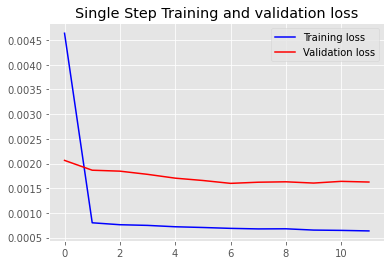

In [649]:
def plot_train_history(history, title):
    loss = history.history['mse']
    val_loss = history.history['val_mse']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()
plot_train_history(history_CNN_LSTM,
                   'Single Step Training and validation loss')

In [650]:
# evaluate the keras model
loss3, mae3, mse3 = CNN_LSTM.evaluate( X_test, Y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae3))

900/900 - 2s - loss: 9.6024e-04 - mae: 0.0152 - mse: 9.6024e-04
Testing set Mean Abs Error:  0.02 MPG
